# Transfer Learning (Feature Extraction) with Data Augmentation

In [1]:
#instantiating the vgg16 convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False,
                 input_shape=(150,150,3))

In [3]:
#adding a densely connected classifier on top of the convolutional base
from keras import models 
from keras import layers

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier you’re adding on top has 2 million parameters. Before you compile and train the model, it’s very important to freeze the convolu-
tional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously
learned

In [5]:
print("This is the number of trainable weights before freezing the conv base: ", len(model.trainable_weights))

conv_base.trainable = False

print("This is the number of trainable weights after freezing the conv base: ", len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30
This is the number of trainable weights after freezing the conv base:  4


With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector).

Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.

Now you can start training your model, with data-augmentation configuration.

In [6]:
import os

base_dir = "cats_and_dogs_small"
train_dir = os.path.join(base_dir,"train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [7]:
#training the model end-to-end with a frozen convolutional base
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
#calculate steps_per_epoch
batch_size = 20
total_train_samples = 1000
steps_per_epoch = total_train_samples // batch_size
steps_per_epoch

50

In [11]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=2e-5),
             metrics=['acc'])

history=model.fit_generator(train_generator,
                           steps_per_epoch=100,
                           epochs=30,
                           validation_data=validation_generator,
                           validation_steps=50)

C:\Users\oo_wa\AppData\Local\Temp\ipykernel_19680\695174961.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,


Epoch 1/30
100/100 [==============================] - 202s 2s/step - loss: 0.5816 - acc: 0.7105 - val_loss: 0.4379 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 188s 2s/step - loss: 0.4815 - acc: 0.7930 - val_loss: 0.3676 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 211s 2s/step - loss: 0.4279 - acc: 0.8105 - val_loss: 0.3327 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 196s 2s/step - loss: 0.4052 - acc: 0.8210 - val_loss: 0.3071 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 212s 2s/step - loss: 0.3772 - acc: 0.8385 - val_loss: 0.2933 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 202s 2s/step - loss: 0.3734 - acc: 0.8375 - val_loss: 0.2894 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 213s 2s/step - loss: 0.3573 - acc: 0.8565 - val_loss: 0.2733 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 238s 2s/step - 

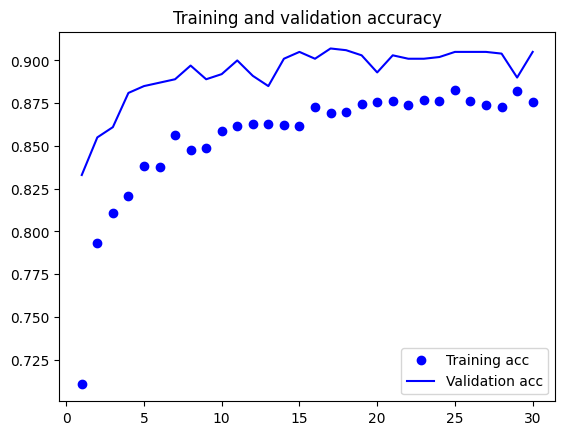

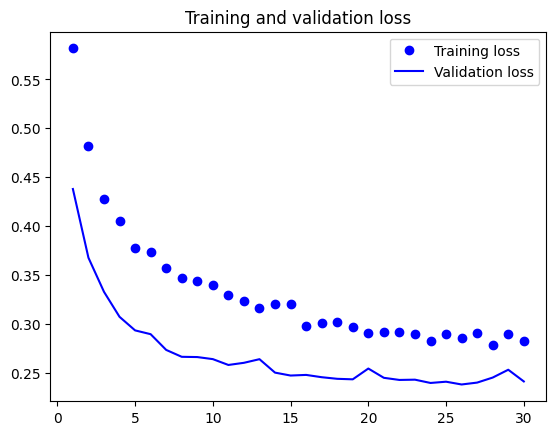

In [12]:
#plotting the results
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()